___
# <font color= #d4b1e6> **Proyecto 1: Análisis de Sentimientos** </font>
- <Strong> Nombre de los integrantes: </Strong>  <font color="blue">`Sarah Lucía Beltrán, Priscila Cervantes Ramírez & Mónica Ibarra Herrera` </font>
- <Strong> Materia: </Strong>  <font color="blue">`Minería de Textos` </font>
___

A continuación se trabajará con un dataset que contiene reseñas de películas que están etiquetadas como positivas y negativas.

En este proyecto se implementarán y compararán modelos basados en n-grams (unigramas, bigramas y trigramas) enfocados en la clasificación de texto. El objetivo es evaluar cómo los diferentes tamaños de n-gramas influyen en el desempeño de los algoritmos que se emplearán. 

Los modelos que se incluirán son los siguientes:
- Regresión Logística 
- Naive Bayes
- SVM

Para cada uno de los modelos mencionados anteriormente se obtendrán diferentes métricas como Accuracy, Precision, Recall y F1-Score.

Se harán evaluaciones y se determinará cuál fue el modelo con el mejor desempeño, así como se revisarán algunos errores que hicieron los modelos para identificar por qué predijo mal, ya sea porque la reseña era de sarcasmo, negación, etc.

### <font color= #d4b1e6> **Librerías a utilizar** </font>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import random

### <font color= #d4b1e6> **Importación de los datos** </font>

In [3]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


*Visualizar que no haya valores nulos*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### <font color= #d4b1e6> **División train/test** </font>

In [5]:
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42, stratify=df['sentiment'])

print("Tamaño train:", len(train_df))
print("Tamaño test:", len(test_df))


Tamaño train: 25000
Tamaño test: 25000


Se usarán el 50% es decir 25,000 reseñas para entrenar a los modelos y las reseñas restantes, se usarán para probar su rendimiento.

### <font color= #d4b1e6> **Pre-Procesamiento** </font>

In [6]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Se utilizó la librería NLTK (Natural Language Toolkit) para realizar la tokenización del texto. Para ello fue necesario descargar los recursos *punkt*, *punkt_tab* y *stopwords*.

- *punkt* permite dividir de manera automática un texto en oraciones y palabras (tokens). 

- *punkt_tab* contiene información extra para que funcione de manera correcta el tokenizador.

- *stopwords* que contiene un listado de palabras muy frecuentes en el idioma (como the, is, and) que suelen eliminarse por no aportar valor al analizar texto.

De esta forma, se asegura que cada reseña se transforme en una secuencia de palabras significativas antes de construir representaciones con n-gramas.

*Limpieza de reseñas*

In [7]:
STOPWORDS = set(stopwords.words("english"))
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

- *STOPWORDS* importa una lista de stopwords en inglés desde NLTK y las convierte en un conjunto para que las búsquedas sean más rápidas cuando se filtre texto.
- *PUNCT_TABLE* crea una tabla de traducción que sirve para eliminar todos los signos de puntuación, limpia el texto quitando las puntuaciones.

In [8]:
def preprocess_text(text, remove_stopwords=False):
    # Minúsculas
    text = text.lower()
    # Eliminar HTML
    text = re.sub(r"<.*?>", " ", text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar tokens que no son alfanuméricos
    tokens = [t for t in tokens if any(c.isalnum() for c in t)]
    # Eliminar stopwords si se requiere
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    return " ".join(tokens)

# Aplicamos a train y test
train_df["clean_review"] = train_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))
test_df["clean_review"] = test_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))

train_df.head()

,review,sentiment,clean_review
3055,Trio's vignettes were insightful and quite enj...,positive,trio 's vignettes were insightful and quite en...
47326,I had never heard of this one before the owner...,negative,i had never heard of this one before the owner...
48869,This is an excellent but hard to find trippy W...,positive,this is an excellent but hard to find trippy w...
48623,"I am a huge fan of big, loud, trashy, complete...",positive,i am a huge fan of big loud trashy completely ...
39657,"Easily Lucio Fulci's most respected film, ""Don...",positive,easily lucio fulci 's most respected film do n...


Se implementa una función de preprocesamiento de texto que:

1) Convierte todo a minúsculas.

2) Elimina etiquetas HTML.

3) Tokeniza las reseñas en palabras individuales.

4) Filtra tokens que no son letras o números como signos de puntuación

5) Opcionalmente elimina stopwords.

Se decidió no eliminar las stopwords durante el preprocesamiento, ya que en análisis de sentimientos estas palabras pueden cambiar el significado de una oración. Palabras como ‘not’, ‘never’ o ‘don’t’ son esenciales para que el modelo identifique correctamente si la reseña es positiva o negativa. 

De esta manera, se obtiene una columna clean_review con texto más limpio y normalizado, que facilita el posterior análisis y entrenamiento del modelo de clasificación.

*Extracción de características*

In [9]:
# Definir el vectorizador con unigramas, bigramas y trigramas
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=50000) # max_features: limita vocabulario para no explotar la RAM

#  Ajustar al train y transformar
X_train = vectorizer.fit_transform(train_df["clean_review"])
X_test = vectorizer.transform(test_df["clean_review"])

y_train = train_df["sentiment"]
y_test = test_df["sentiment"]

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (25000, 50000)
Shape X_test: (25000, 50000)


Para representar las reseñas se utilizó un CountVectorizer de Scikit-learn para extraer unigramas, bigramas y trigramas. Esto significa que cada reseña se transforma en un vector que refleja la frecuencia de palabras individuales y combinaciones de dos o tres palabras consecutivas. Se limitó el vocabulario a 50,000 características para reducir el consumo de memoria.

El vectorizador se ajusta al conjunto de entrenamiento y luego se aplica al conjunto de prueba usando el mismo vocabulario aprendido, asegurando que la evaluación sea consistente. Las etiquetas de sentimiento se almacenan por separado en y_train y y_test, y las dimensiones de las matrices resultantes reflejan el número de reseñas y la cantidad de n-gramas considerados.

### <font color= #d4b1e6> **Entrenamiento de Modelos** </font> 

#### <font color= #96d9cf> **Regresión Logística** </font> 

In [10]:
logreg = LogisticRegression(max_iter=1000, solver="saga")
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

c:\Users\cesar\anaconda3\envs\iteso\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression
Accuracy: 0.90108
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90     12500
    positive       0.90      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



*Explicación de hiperparámetros*

Para entrenar el modelo de Regresión Logística se utilizó LogisticRegression de Scikit-learn con los hiperparámetros max_iter=1000 y solver="saga".

- *max_iter* de 1000 para asegurar que el algoritmo converja, dado el tamaño y la alta dimensionalidad de los datos de n-grams.

- *solver="saga"* fue elegido por su eficiencia con matrices dispersas y por su capacidad de manejar regularización L1 y L2, características útiles para textos con muchas características.

#### <font color= #96d9cf> **Naive Bayes** </font>

In [11]:
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes
Accuracy: 0.86768
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87     12500
    positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



Se entrenó un modelo Naive Bayes multinomial para clasificar las reseñas en positivas o negativas. Este modelo es adecuado para datos de conteo, como los vectores de n-grams, ya que estima la probabilidad de cada palabra dado el sentimiento de la reseña.

#### <font color= #96d9cf> **SVM** </font>

In [12]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

c:\Users\cesar\anaconda3\envs\iteso\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM
Accuracy: 0.88436
              precision    recall  f1-score   support

    negative       0.89      0.88      0.88     12500
    positive       0.88      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



### <font color= #d4b1e6> **Evaluación** </font> 

In [13]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["positive", "negative"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["positive", "negative"],
                yticklabels=["positive", "negative"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

#### <font color= #96d9cf> **Regresión Logística** </font> 

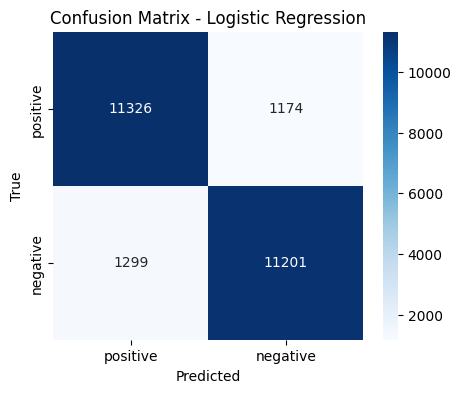

In [14]:
plot_confusion(y_test, y_pred_logreg, "Confusion Matrix - Logistic Regression")

#### <font color= #96d9cf> **Naive Bayes** </font>

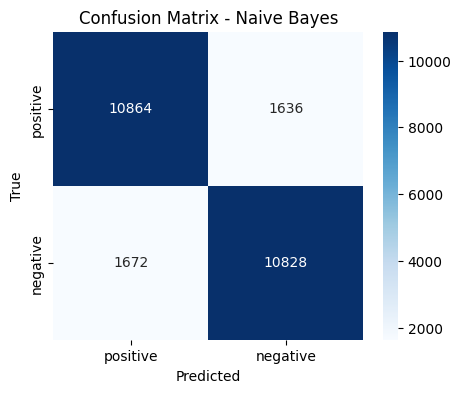

In [15]:
plot_confusion(y_test, y_pred_nb, "Confusion Matrix - Naive Bayes")


#### <font color= #96d9cf> **SVM** </font>

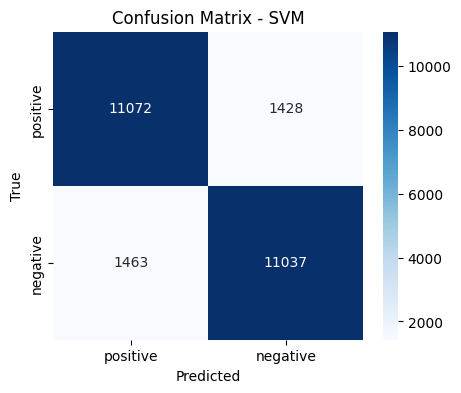

In [16]:
plot_confusion(y_test, y_pred_svm, "Confusion Matrix - SVM")


Modelo: LogisticRegression
Accuracy: 0.9011
Macro - Precision: 0.9011  Recall: 0.9011  F1: 0.9011
Weighted - Precision: 0.9011  Recall: 0.9011  F1: 0.9011

Per-class (positive / negative):
 Precision: 0.8971 / 0.9051
 Recall:    0.9061 / 0.8961
 F1-score:  0.9016 / 0.9006

Classification report:

              precision    recall  f1-score   support

    positive       0.90      0.91      0.90     12500
    negative       0.91      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



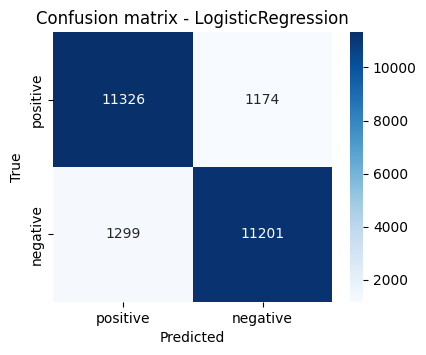


Modelo: MultinomialNB
Accuracy: 0.8677
Macro - Precision: 0.8677  Recall: 0.8677  F1: 0.8677
Weighted - Precision: 0.8677  Recall: 0.8677  F1: 0.8677

Per-class (positive / negative):
 Precision: 0.8666 / 0.8687
 Recall:    0.8691 / 0.8662
 F1-score:  0.8679 / 0.8675

Classification report:

              precision    recall  f1-score   support

    positive       0.87      0.87      0.87     12500
    negative       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



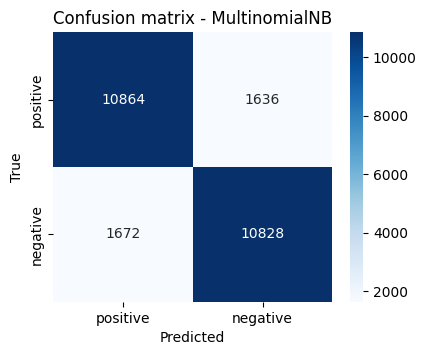


Modelo: LinearSVC
Accuracy: 0.8844
Macro - Precision: 0.8844  Recall: 0.8844  F1: 0.8844
Weighted - Precision: 0.8844  Recall: 0.8844  F1: 0.8844

Per-class (positive / negative):
 Precision: 0.8833 / 0.8854
 Recall:    0.8858 / 0.8830
 F1-score:  0.8845 / 0.8842

Classification report:

              precision    recall  f1-score   support

    positive       0.88      0.89      0.88     12500
    negative       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



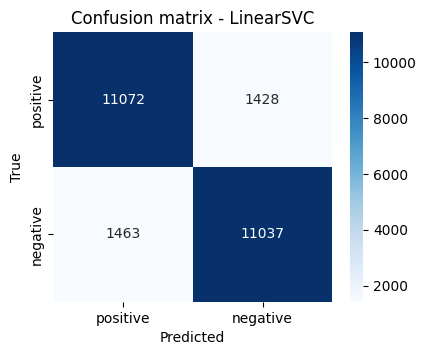

,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,pos_precision,pos_recall,pos_f1,neg_precision,neg_recall,neg_f1
model,,,,,,,,,,,,,
LogisticRegression,0.9011,0.9011,0.9011,0.9011,0.9011,0.9011,0.9011,0.8971,0.9061,0.9016,0.9051,0.8961,0.9006
MultinomialNB,0.8677,0.8677,0.8677,0.8677,0.8677,0.8677,0.8677,0.8666,0.8691,0.8679,0.8687,0.8662,0.8675
LinearSVC,0.8844,0.8844,0.8844,0.8844,0.8844,0.8844,0.8844,0.8833,0.8858,0.8845,0.8854,0.8830,0.8842


In [17]:

# Asegúrate de que y_test y las predicciones existen
models_preds = {
    "LogisticRegression": y_pred_logreg,
    "MultinomialNB": y_pred_nb,
    "LinearSVC": y_pred_svm
}

summary_rows = []

def print_cm(y_true, y_pred, title):
    labels_order = ["positive", "negative"]  # ajusta si tus labels son otras
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plt.figure(figsize=(4.5,3.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

for name, y_pred in models_preds.items():
    # accuracy
    acc = accuracy_score(y_test, y_pred)
    # macro and weighted precision/recall/f1
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
    prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    # per-class metrics (order: positive, negative)
    per_prec, per_rec, per_f1, support = precision_recall_fscore_support(y_test, y_pred, labels=["positive","negative"])
    pos_prec, neg_prec = per_prec[0], per_prec[1]
    pos_rec, neg_rec = per_rec[0], per_rec[1]
    pos_f1,  neg_f1  = per_f1[0], per_f1[1]

    # print human-friendly report
    print("\n" + "="*60)
    print(f"Modelo: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro - Precision: {prec_macro:.4f}  Recall: {rec_macro:.4f}  F1: {f1_macro:.4f}")
    print(f"Weighted - Precision: {prec_weight:.4f}  Recall: {rec_weight:.4f}  F1: {f1_weight:.4f}")
    print("\nPer-class (positive / negative):")
    print(f" Precision: {pos_prec:.4f} / {neg_prec:.4f}")
    print(f" Recall:    {pos_rec:.4f} / {neg_rec:.4f}")
    print(f" F1-score:  {pos_f1:.4f} / {neg_f1:.4f}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, labels=["positive","negative"]))
    print("="*60)

    # add to summary table
    summary_rows.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weight,
        "recall_weighted": rec_weight,
        "f1_weighted": f1_weight,
        "pos_precision": pos_prec,
        "pos_recall": pos_rec,
        "pos_f1": pos_f1,
        "neg_precision": neg_prec,
        "neg_recall": neg_rec,
        "neg_f1": neg_f1
    })

    # show confusion matrix for this model
    print_cm(y_test, y_pred, f"Confusion matrix - {name}")

# show summary dataframe
summary_df = pd.DataFrame(summary_rows).set_index("model")
display(summary_df.round(4))


### <font color= #d4b1e6> **Análisis de Error** </font> 

In [18]:
# Escogemos un modelo para analizar (ej. Logistic Regression)
y_pred = y_pred_logreg  

# Encuentra índices de errores
errores_idx = [i for i, (y_true, y_hat) in enumerate(zip(y_test, y_pred)) if y_true != y_hat]

print("Total errores:", len(errores_idx))

# Muestra algunos ejemplos al azar usando el texto original
for i in random.sample(errores_idx, 5):
    print("="*80)
    print("🔹 Review original:")
    print(test_df.iloc[i]["review"])   # aquí usamos test_df, no X_test
    print("✅ Sentiment real:", test_df.iloc[i]["sentiment"])
    print("❌ Predicción modelo:", y_pred[i])

Total errores: 2473
🔹 Review original:
Ah, here it is! A movie, which is said by people to remind me of the epic "Trainspotting". OUCH, was I a fool to believe that, and OUCH, how my buttocks hurt after having forced myself to watch this c**p from beginning to end. After the first 10-15 minutes I just wanted it all to end, or at least they could've put some nudity or action or cool acid house music into it to make it worth the time... But no, when I was through with it, i put it into my CD shelf and I hope I will never have to pick it out again just to show it to some friend who is so anxious to see it that he/she don't want to listen to my warnings.
✅ Sentiment real: negative
❌ Predicción modelo: positive
🔹 Review original:
In this early Fulci work the director shows his most mainstream side as well as a talent for compelling storytelling and more than reasonable elucidation for the genre. Personally I think he has been unfairly maligned throughout his career as an aesthete of gore. I